In [12]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math
import itertools
from Datasets import wind_order_forcings, warm_order_forcings,\
exp_set_dict_wind_order, exp_set_dict_warm_order,\
colors_dict, all_runs_wind_order
import Functions_data_analysis as fda
import Functions_load_output as flo
import Functions_plotting as fp
import xarray as xr
import string

In [2]:
# Use importlib to reload modules after editing them
import importlib
importlib.reload(fp)

<module 'Functions_plotting' from '/glade/campaign/univ/uwas0134/Gemma/Analysis/Final Submission Figs/Functions_plotting.py'>

In [3]:
# set up data retrieval params
sets = ['ic_1995','ic_2001','ic_2008']

here


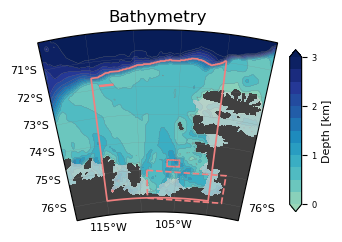

In [4]:
# Show locations of analyses on bathymetry map

# sb_tcd loc
loc1 = 'COT'
# inner_shelf_tcd loc
loc2 = 'PITT'
# total shelf CDW volume loc
loc3 = 'naughten_shelf_box' # same as in naughten et al. 2022
# ice shelf melt loc
loc4 = 'inner_shelf_corner' #includes only Thwaites and PIG ice shelves

fp.plot_bathymetry_and_locs('AS_near', [loc1,loc2,loc3,loc4])

In [5]:
# Set up TCD calc and save arrays

def calc_tcd(loc, tc_temp, n_months, sets):
    """
    Calculate tcd at a given location for a given tc temp, number of months, and sets
    Inputs
    ------
    loc: str
        corresponding to locations in functions_data_analysis
    tc_temp: float
        temp to use for thermocline depth
    n_months: int
        number of months of model output to use in each experiment (max 60 for 5-yr exps)
    sets: list of strings
        Options for strings: 'control','ic_1995','ic_2001','ic_2008'
    Outputs
    -------
    None
        Saves tcd as numpy arrays, grouped by set, ordered in wind_order_forcings. 
    """
    tc_depths = []
    times = []
    labs = []
    tcd_means = []
    tcd_stds = []
    run_names = []
    for set_name in sets:
        print(set_name)
        
        # If tc depths precalculated, load arrays. Otherwise, calculate and save. 
        try:
            set_tcd = np.load('../Saved Arrays/tcd_'+str(tc_temp)+'deg_tseries_'+loc1+'_'+set_name+'.npy')
            set_times = np.load('../Saved Arrays/times_'+set_name+'.npy')
            print('TCD already exist for set ',set_name,'! Not saving')
        except:
            print('Calculating tc depths for',set_name)
            set_list = exp_set_dict_wind_order[set_name]
            set_tcd, set_times = fda.calc_tc_depth_tseries(set_list, loc1, tc_temp,n_months = n_months)
            if save_new_tcd_arrays:
                tcd_fname = 'tcd_'+str(tc_temp)+'deg_tseries_'+loc1+'_'+set_name+'.npy'
                times_fname = 'times_'+set_name+'.npy' 
                np.save('../Saved Arrays/'+tcd_fname, set_tcd)
                np.save('../Saved Arrays/'+times_fname, set_times)
                print('Saved new tcd and time arrays as:','../Saved Arrays/'+tcd_fname)
        print('TDC retrieved with shape:',set_tcd.shape)
        for i in range(len(set_tcd)):
            tc_depths.append(set_tcd[i])
            times.append(set_times)
            if 'control' in set_name:
                labs.append('Control')
                run_name = 'Control'
            else:
                labs.append(str(wind_order_forcings[i]))
                run_name = set_name+'_'+str(wind_order_forcings[i])
            run_names.append(run_name)
                
            # Calculate mean of tc depth for each run (set to 0 if contains nans, otherwise makes it looks warmer than it is)
            mean = np.mean(set_tcd[i])
            std = np.std(set_tcd[i])
            if np.isnan(mean):
                tcd_means.append(0)
                tcd_stds.append(0)
            else:
                tcd_means.append(round(mean,2))
                tcd_stds.append(round(std,2))

    return


# Save TCD at shelf break
tc_temp = 0.5
n_months = 60
calc_tcd(loc1, tc_temp, n_months, sets)

# Save TCD at inner shelf
tc_temp = 0.5
n_months = 60
calc_tcd(loc2, tc_temp, n_months, sets)

ic_1995
TCD already exist for set  ic_1995 ! Not saving
TDC retrieved with shape: (10, 60)
ic_2001
TCD already exist for set  ic_2001 ! Not saving
TDC retrieved with shape: (10, 60)
ic_2008
TCD already exist for set  ic_2008 ! Not saving
TDC retrieved with shape: (10, 60)
ic_1995
TCD already exist for set  ic_1995 ! Not saving
TDC retrieved with shape: (10, 60)
ic_2001
TCD already exist for set  ic_2001 ! Not saving
TDC retrieved with shape: (10, 60)
ic_2008
TCD already exist for set  ic_2008 ! Not saving
TDC retrieved with shape: (10, 60)


In [6]:
# Calculate CDW volume timeseries for all runs and save arrays

# parameters-------------------------

runs = ['control']+all_runs_wind_order
cdw_volumes = []
times_list = []
labs = []
cdw_min_temp = 0.5
n_months = 60
region = 'naughten_shelf_box'


# calculate shelf grid areas-------------------------

# get a random run
exp1_ds = flo.load_experiment_ds(runs[1], 'all', 'state_3d_set2')
run_ds = exp1_ds.isel(time = slice(0,n_months))
exp1_T_raw = exp1_ds.THETA
exp1_T_mid_depths = exp1_T_raw.sel(depth=slice(-200,-1500))
# Select data from shelf region
if region in fda.analysis_region_dict.keys():
    lat1,lat2,lon1,lon2 = fda.analysis_region_dict[region]
    exp1_T = exp1_T_mid_depths.sel(lat = slice(lat1,lat2),lon=slice(lon1,lon2))
# calc grid areas
shelf_grid_areas = fda.calc_grid_areas(exp1_T)

# calc CDW volume-------------------------

for run in runs:
    # try loading precalc CDW volume
    try:
        cdw_vol = np.load('../Saved Arrays/CDW_Volume/'+run+'_'+str(cdw_min_temp)+'deg_'+region+'.npy')
        if run == 'control':
            vol_times = np.load('../Saved Arrays/CDW_Volume/times_control.npy')
            labs.append('control')
        else:
            ic_set = run.split('rep_ic_')[1]
            vol_times = np.load('../Saved Arrays/CDW_Volume/times_ic_'+ic_set+'.npy')
            labs.append(run.split('run_forc_erai_')[1][0:4])
        print('Precalculated CDW volume found for run',run,'. Not saving!')
    # Otherwise, calculate from scratch and save arrays
    except:
        print('calculating CDW volume for run',run)
        if run != 'control':
            vol_times, cdw_vol = fda.calc_cdw_volume_tseries(run, region, cdw_min_temp, shelf_grid_areas, n_months = n_months)
            save_name = '../Saved Arrays/CDW_Volume/'+run+'_'+str(cdw_min_temp)+'deg_'+region+'.npy'
            print('Saving new CDW volume array as ',save_name)
            np.save(save_name,cdw_vol)
            ic_set = run.split('rep_ic_')[1]
            try:
                vol_times = np.load('../Saved Arrays/CDW_Volume/times_ic_'+ic_set+'.npy')
            except:
                np.save('../Saved Arrays/CDW_Volume/times_ic_'+ic_set+'.npy',vol_times)
        else:
            labs.append('control')
            # load full run for control run
            vol_times, cdw_vol = fda.calc_cdw_volume_tseries(run, region, cdw_min_temp, shelf_grid_areas)
            save_name = '../Saved Arrays/CDW_Volume/'+run+'_'+str(cdw_min_temp)+'deg_'+region+'.npy'
            print('Saving new CDW volume array as ',save_name)
            np.save(save_name,cdw_vol)
            np.save('../Saved Arrays/CDW_Volume/times_control.npy',vol_times)
   
    cdw_volumes.append(cdw_vol)
    times_list.append(vol_times)


distance between first set of lats: -70.81403 -70.839806 : 2865.726182596398 meters
distance between first set of lons: -114.958336 -114.875 , 9266.526670368372 meters
Precalculated CDW volume found for run control . Not saving!
Precalculated CDW volume found for run run_forc_erai_2015_rep_ic_1995 . Not saving!
Precalculated CDW volume found for run run_forc_erai_1991_rep_ic_1995 . Not saving!
Precalculated CDW volume found for run run_forc_erai_1982_rep_ic_1995 . Not saving!
Precalculated CDW volume found for run run_forc_erai_1994_rep_ic_1995 . Not saving!
Precalculated CDW volume found for run run_forc_erai_1992_rep_ic_1995 . Not saving!
Precalculated CDW volume found for run run_forc_erai_1984_rep_ic_1995 . Not saving!
Precalculated CDW volume found for run run_forc_erai_2009_rep_ic_1995 . Not saving!
Precalculated CDW volume found for run run_forc_erai_2003_rep_ic_1995 . Not saving!
Precalculated CDW volume found for run run_forc_erai_1989_rep_ic_1995 . Not saving!
Precalculated C

In [7]:
# get shelf break tcd for subplot 1

p1_data = [] #list of length n_sets. each item contains data for each ic_set
for set_name in sets:
    set_tcd = np.load('../Saved Arrays/tcd_'+str(tc_temp)+'deg_tseries_'+loc1+'_'+set_name+'.npy')
    p1_data.append(set_tcd)

In [8]:
# get PITT tcd for subplot 2

p2_data = [] 
for set_name in sets:
    set_tcd = np.load('../Saved Arrays/tcd_'+str(tc_temp)+'deg_tseries_'+loc2+'_'+set_name+'.npy')
    p2_data.append(set_tcd)

In [9]:
# get total shelf CDW volume for subplot 3

# these data are saved by run, not set
runs_nested = [exp_set_dict_wind_order[set] for set in sets]
p3_data = []
for set_i in range(len(runs_nested)):
    set_runs = runs_nested[set_i]
    set_vols = []
    for run_name in set_runs:
        run_vol = np.load('../Saved Arrays/CDW_Volume/'+run_name+'_'+str(tc_temp)+'deg_'+loc3+'.npy')
        set_vols.append(run_vol)
    p3_data.append(set_vols)

In [10]:
# Get ice shelf melt rates for row 4

# these data are saved by run, not set
runs_nested = [exp_set_dict_wind_order[set] for set in sets]
p4_data = []
# ice_fw_loc = 'PIG_shelf'
ice_fw_loc = 'inner_shelf_corner'
units = 'm/yr' #arrays are saved in m/yr
# units = 'Gt/yr'
if units == 'Gt/yr':
    # convert to Gt/yr by getting ice shelf area from an example experiment
    lat1, lat2, lon1, lon2 = fda.analysis_region_dict[ice_fw_loc]
    exp_ice_fw_full = flo.load_experiment_ds('run_forc_erai_1982_rep_ic_2001', 'all', 'iceshelf_state_set2').SHIfwFlx
    exp_ice_fw_reg = exp_ice_fw_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    exp_ice_fw_reg = exp_ice_fw_reg.isel(time=59)
    region_areas = fda.calc_grid_areas(exp_ice_fw_reg) # calc grid sizes of inner shelf corner
    region_area = np.sum(region_areas)
    ice_shelf_areas = region_areas[np.where(exp_ice_fw_reg != 0)] # only keep grid sizes where ice shelves are
    ice_shelf_area = np.sum(ice_shelf_areas) # PIG + Thwaites areas in m^2
    print("model region area: {:.2e}".format(region_area) + "; model ice shelf area: {:.2e}".format(ice_shelf_area))
for set_i in range(len(runs_nested)):
    set_runs = runs_nested[set_i]
    set_melts = []
    for run_name in set_runs:
        run_melt = np.load('../Saved Arrays/Ice_shelf_melt_rate/'+run_name+'_'+ice_fw_loc+'.npy')
        if units == 'Gt/yr':
            run_melt = run_melt * ice_shelf_area * 917  / 10e12
        set_melts.append(run_melt)
    p4_data.append(set_melts)


In [29]:
# Save all 4 variables into one netCDF file for each experiment set for uploading to Zenodo. 

# ic_str_list = ['warm', 'moderate', 'cool']
# exp_set_dict = {'moderate':'ic_2001','warm':'ic_1995','cool':'ic_2008'}

# #loop through each ic set
# for i in range(3):
#     ic_str = ic_str_list[i]
#     exp_set = exp_set_dict[ic_str]
#     runs = exp_set_dict_wind_order[exp_set]
#     times = np.load('../Saved Arrays/times_'+exp_set+'.npy')
#     var_names = ['shelf_break_tcd','inner_shelf_tcd','cdw_volume','ice_shelf_melt_rate']
#     data_arrays = [p1_data[i],p2_data[i],p3_data[i],p4_data[i]] #follows order of var_names
#     data_var_dict = {}
#     for var_name, data_array in zip(var_names, data_arrays):
#         data_var_dict[var_name] = (('run','time'), data_array)
#     ds = xr.Dataset(data_vars = data_var_dict,
#                     coords = {'run':runs, 'time':times},
#                     attrs = {"description":"Shelf break thermocline depths, inner shelf thermocline depths, "
#                              "on-shelf CDW volume, and inner shelf ice-shelf melt rates in the "+ic_str+
#                              " initial condition experiment set"})
#     fname = 'Submission Data/Simulated_time_series/Thermocline_depth_CDW_volume_melt_rate_'+ic_str+'_ic.nc'
#     ds.to_netcdf(fname)
#     print(ds)
#     print('Saved as',fname)

<xarray.Dataset>
Dimensions:              (run: 10, time: 60)
Coordinates:
  * run                  (run) <U30 'run_forc_erai_2015_rep_ic_1995' ... 'run...
  * time                 (time) datetime64[ns] 1995-02-01 ... 2000-01-01
Data variables:
    shelf_break_tcd      (run, time) float64 -215.3 -215.3 ... -281.3 -259.3
    inner_shelf_tcd      (run, time) float64 -303.3 -303.3 ... -435.3 -435.3
    cdw_volume           (run, time) float64 2.232e+14 2.214e+14 ... 1.724e+14
    ice_shelf_melt_rate  (run, time) float32 13.56 13.34 13.73 ... 9.851 10.04
Attributes:
    description:  Shelf break thermocline depths, inner shelf thermocline dep...
Saved as Submission Data/Simulated_time_series/Thermocline_depth_CDW_volume_melt_rate_warm_ic.nc
<xarray.Dataset>
Dimensions:              (run: 10, time: 60)
Coordinates:
  * run                  (run) <U30 'run_forc_erai_2015_rep_ic_2001' ... 'run...
  * time                 (time) datetime64[ns] 2001-02-01 ... 2006-01-01
Data variables:
    shel

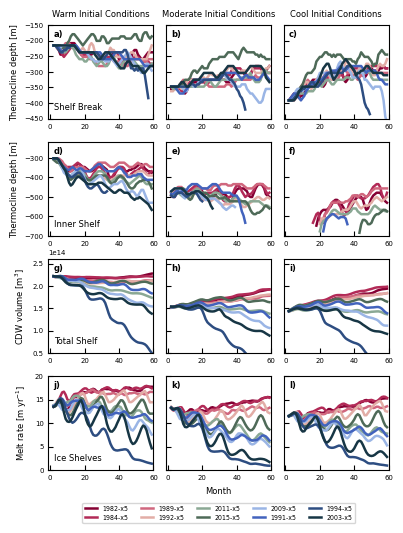

In [26]:
# Plot all exp set data for all 3 locations

plot_data = [p1_data,p2_data,p3_data,p4_data]
lims = [[-450,-150],[-700,-220],[0.5e14,2.6e14],[0,20]]
ic_labs = ['Warm Initial Conditions','Moderate Initial Conditions','Cool Initial Conditions']
titles = ['Shelf Break','Inner Shelf','Total Shelf','Ice Shelves']
left_labs = ['Thermocline depth [m]','Thermocline depth [m]',r'CDW volume [$\mathrm{m}^3$]',r'Melt rate [$\mathrm{m}~\mathrm{yr}^{-1}$]']
right_labs = ['TCD [m]','TCD [m]',r'volume [$m^3$]','Melt rate [m yr]']
months = np.arange(0,60,1) #label x axis months as 0 to 60
change_x_vals = np.linspace(62,77,10) #create arbitrary x vals for plotting 5-yr changes
change_lims = [[-90,190],[-190,150],[-0.82e14,0.6e14],[-10,5]]
sub_labels = list(string.ascii_lowercase[:12])  # ['a', 'b', ..., 'l']

colors_dict =  {'1982_x5':"#850033",
                '1984_x5':"#b22a57",
                '1989_x5':"#d0677e",
                '1992_x5':"#e2ada6",
                '2011_x5':"#8AA894",
                '2015_x5':"#4E6A58",
                '2009_x5':"#9ab5e5",
                '1991_x5':"#4263bd",
                '1994_x5':"#2d4d81",
                '2003_x5':"#173645"}
exp_plot_order = list(colors_dict.keys())

fig = plt.figure()
fig.set_size_inches((4.1,5.36))
plot_ct = 1
change_vals = []
axes = []

# Plot each row (each loc)
for row_i in range(4):

    #get location data
    row_data = plot_data[row_i]
    
    # Plot each set in a new subplot
    for set_j in range(3):
        
        ax0 = fig.add_subplot(4,3,plot_ct)
        # ax1 = ax0.twinx()
        axes.append(ax0)
        # axes.append(ax1)
        set_data = row_data[set_j]
        change_vals.append(sets[set_j])
        
        if set_j == 0:
            ax0.annotate(titles[row_i],(.05,0.1),xycoords = ('axes fraction'),fontsize=6)
        if row_i == 0:
            plt.title(ic_labs[set_j],fontsize=6)
        
        # Plot 10 experiments in each set
        for k in range(10):
            
            #get forcing name
            forc_k = exp_plot_order[k] #'YYYY-x5'
            # get index of experiment in wind-ordered tcds
            tcd_idx = wind_order_forcings.index(int(forc_k[0:4])) #int for list of int years)
            
            # Calc 3-month running mean to smooth out tseries
            data_rm = pd.Series(set_data[tcd_idx]).rolling(window=3).mean()
            ax0.plot(months, data_rm, label=forc_k.replace('_','-'), 
                    color = colors_dict[forc_k],linewidth=1.8)
            
        # adjust plot params
        ax0.set_ylim(lims[row_i])
        ax0.set_xlim([-1,60]) #80 if showing change
        ax0.set_xticks([0,20,40,60])
        # ax1.set_ylim(change_lims[row_i])
        ax0.tick_params(axis='both', direction='in', which='both')
        # ax1.tick_params(axis='both', direction='in', which='both')
    
        if plot_ct == 11:
             ax0.set_xlabel('Month',fontsize=6)
        
        if set_j == 0:
            ax0.set_ylabel(left_labs[row_i],fontsize=6)
        else:
            ax0.set_yticklabels([])

        # add letter label
        label = f"{sub_labels[plot_ct-1]})"
        ax0.text(0.05, 0.95, label, transform=ax0.transAxes,
            fontsize=6, fontweight='bold', va='top', ha='left')
        plot_ct += 1
        
for ax in axes:
    ax.tick_params(axis='x', labelsize=5)
    ax.tick_params(axis='y', labelsize=5)
    ax.yaxis.get_offset_text().set_fontsize(5)
    
        
        
# Add legend
handles, labels = ax0.get_legend_handles_labels()
legend = plt.legend(handles[:10], labels[:10], loc='lower center', bbox_to_anchor=(-0.62, -0.6), ncol=5,fontsize=4.5)

# Save fig
plt.subplots_adjust(top=0.95,bottom=0.12,hspace=0.25,wspace=.12,left=0.12,right=.95)
plt.savefig('Plots/Figure_ED_1_all_metrics_all_exps.jpg',dpi=800)
# print('saved fig!')

In [29]:
# Get control run melt rates

# get ice shelf fw fluxes
ctrl_ice_fw_loc = 'inner_shelf_corner'
lat1, lat2, lon1, lon2 = fda.analysis_region_dict[ctrl_ice_fw_loc]
ctrl_ice_fw_full = flo.load_experiment_ds('control', 'all', 'iceshelf_state_set2').SHIfwFlx
ctrl_ice_fw_reg = ctrl_ice_fw_full.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
ctrl_ice_fw_nan = ctrl_ice_fw_reg.where(ctrl_ice_fw_reg != 0)
ctrl_ice_fw_nan_tseries = ctrl_ice_fw_nan.mean(dim='lat')
ctrl_ice_fw_tseries = ctrl_ice_fw_nan_tseries.mean(dim='lon')

# #get PIG ice shelf area
# ctrl_region_areas = fda.calc_grid_areas(ctrl_ice_fw_reg) # calc grid sizes of inner shelf corner
# ctrl_ice_shelf_areas = ctrl_region_areas[np.where(ctrl_ice_fw_reg != 0)] # only keep grid sizes where ice shelves are
# ctrl_ice_shelf_area = np.sum(ctrl_ice_shelf_areas) # PIG + Thwaites areas in m^2

#convert to m/yr
rho_fw = 1000
sec_per_year = 60*60*24*365.25
ctrl_melt_rate = ctrl_ice_fw_tseries / rho_fw * sec_per_year


Text(0.5, 1.0, 'Control run ice shelf melt rate')

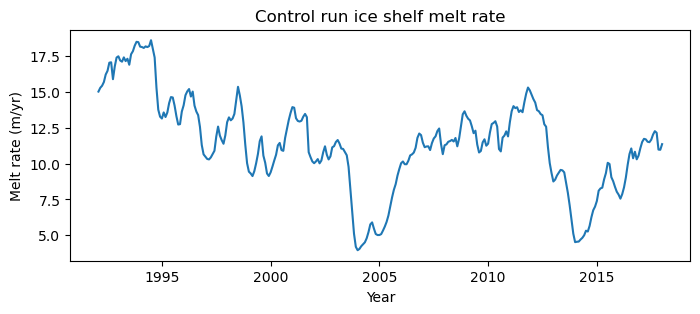

In [30]:
# Plot control run melt rates
plt.figure(figsize=(8,3))
plt.plot(np.linspace(1992+(1/12),2018,312,endpoint=True),-ctrl_melt_rate)
plt.ylabel('Melt rate (m/yr)')
plt.xlabel('Year')
plt.title ('Control run ice shelf melt rate')

In [31]:
# Get min, mean, and max of control run melt rates
ctrl_melt = -ctrl_melt_rate.values
np.min(ctrl_melt), np.mean(ctrl_melt), np.max(ctrl_melt)

(3.9670162, 11.39607, 18.583807)

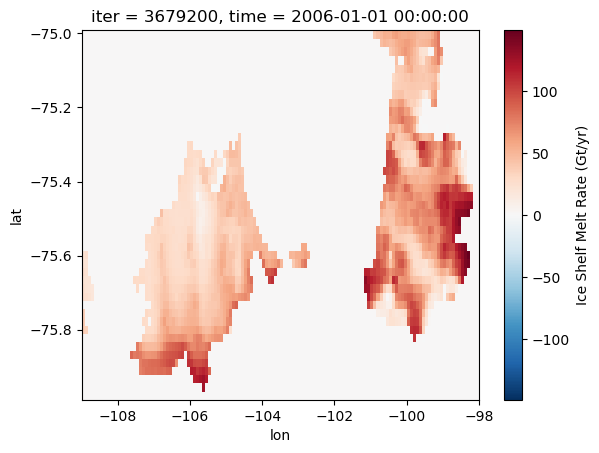

In [86]:
# Plot ice shelf melt region at a random timestep to visualize area
rho_fw = 1000
sec_per_year = 60*60*24*365.25
melt_rate = -exp_ice_fw_reg/rho_fw*sec_per_year
discharge_rate = melt_rate * ice_shelf_area * 917 / 10e12
(discharge_rate).plot(cbar_kwargs={'label':'Ice Shelf Melt Rate (Gt/yr)'})